# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [269]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import KMeans

# model building 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

# processing and analysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 400)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [270]:
# All data files
datafile_germany_clean = "./data/cleaned_germany.csv"
datafile_customer_clean = "./data/cleaned_customer.csv"
datafile_germany_pca = "./data/pca_germany.csv"
datafile_customer_pca = "./data/pca_customer.csv"
datafile_germany_raw = "./data/Udacity_AZDIAS_052018.csv"
datafile_customer_raw = "./data/Udacity_CUSTOMERS_052018.csv"
dataset_training = "./data/Udacity_MAILOUT_052018_TRAIN.csv"


In [271]:
def load_dataset(data_type = "raw"):
    """
    Loads germany, customer, attribute values and attribute information data
    
    Args:
        data_type to load, use values from "raw", "cleaned"
    
    Returns:
        germany : Global data
        customer : Customers data
        attr_vals : Attribute values data
        attr_info : Attribute information data
    """
    load_cleaned = False
    
    cleaned_present = False
    if data_type == "cleaned":
        load_cleaned = True
        cleaned_present = os.path.isfile(datafile_germany_clean) & os.path.isfile(datafile_customer_clean)
        if cleaned_present:
            print("found clean dataset...")
        else:
            print("cleaned data is missing!!!!")
                
    # Ignore any empty columns while loading data
    named = lambda x: 'Unnamed' not in x

    if load_cleaned and cleaned_present:
        print("Loading cleaned data")
        germany = pd.read_csv(datafile_germany_clean, usecols=named)
        customer = pd.read_csv(datafile_customer_clean, usecols=named)
    else:
        print("Loading raw data")
        germany = pd.read_csv(datafile_germany_raw, sep=';')
        customer = pd.read_csv(datafile_customer_raw, sep=';')

    attr_vals = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=named)
    attr_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=named)    
    
    return germany, customer, attr_vals, attr_info

In [272]:
# load in the data (raw)
germany, customer, attributes_values, attributes_info = load_dataset()

Loading raw data


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [273]:
print('Shape of germany dataset: ',germany.shape)
print('Shape of customer dataset: ',customer.shape)

# Inspect germany data layout
print(germany.describe())
print(customer.describe())

Shape of germany dataset:  (891221, 366)
Shape of customer dataset:  (191652, 369)
                LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7

In [274]:
# Map attributes from dataset

attributes_values.head(10)
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()

In [275]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [276]:
attributes_info.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


### Part 0.1: Clean and transform data


In [277]:
#inspect_cols = ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]
inspect_cols = ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]

for col in inspect_cols:
    print("Analyzing col:", col)
    print('germany')
    print(germany[col].unique())
    print('customer')
    print(customer[col].unique())
        

Analyzing col: EINGEFUEGT_AM
germany
[nan '1992-02-10 00:00:00' '1992-02-12 00:00:00' ... '2010-12-02 00:00:00'
 '2005-03-19 00:00:00' '2011-11-18 00:00:00']
customer
['1992-02-12 00:00:00' nan '1992-02-10 00:00:00' ... '2008-04-25 00:00:00'
 '2005-03-30 00:00:00' '2008-07-14 00:00:00']
Analyzing col: D19_LETZTER_KAUF_BRANCHE
germany
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']
customer
['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 

In [278]:
# Too many uniques vals, dropping from dataset

def remove_special_cols(df):
    special_cols = ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    for col in inspect_cols:
        df = df.drop([col],axis=1)
    return df

germany = remove_special_cols(germany)
customer = remove_special_cols(customer)

print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)

Final shape of germany dataset:  (891221, 363)
Final shape of customers dataset:  (191652, 366)


In [279]:
# Do we have cols with non-numeric data values
print("============== cols with no-numeric values==========")
print(germany.select_dtypes(include=['object']))
print("====================================================")

# doublecheck the identified cols
all_cols = germany.columns
numeric_cols = germany._get_numeric_data().columns
print('columns with numeric values: ',numeric_cols)
object_cols = list(set(all_cols) - set(numeric_cols))
print('columns with object fields: ',object_cols)

for col in object_cols:
    print('Before fixing col values in:', col)
    print(germany[col].unique())
    print(customer[col].unique())


============== cols with no-numeric values==========
       CAMEO_DEUG_2015 CAMEO_INTL_2015 OST_WEST_KZ
0                  NaN             NaN         NaN
1                    8              51           W
2                    4              24           W
3                    2              12           W
4                    6              43           W
...                ...             ...         ...
891216               7              41           W
891217               9              51           W
891218               4              24           W
891219               9              51           W
891220               6              43           W

[891221 rows x 3 columns]
columns with numeric values:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 

In [280]:
# Lets replace all na, X and XX's with a standard numeric values i.e -1

print('Initial shape of germany dataset: ',germany.shape)
print('Initial shape of customers dataset: ',customer.shape)

def fix_cameo_cols(df):
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    for col in cols:
        if col in df.columns:
            df[col] = df[col].replace({"X": np.nan, "XX": np.nan})
            df[col] = df[col].astype(float)
    
    return df

def fix_col_mappings(df):
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "WOHNLAGE"]
    
    for col in cols:
        if col in df.columns:
            df[col] = df[col].replace({0: np.nan})
            df[col] = df[col].astype(float)
    
    if "OST_WEST_KZ" in df.columns:
        df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})   
        
    if "ANREDE_KZ" in df.columns:
        df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

Initial shape of germany dataset:  (891221, 363)
Initial shape of customers dataset:  (191652, 366)


In [281]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

germany = fix_cameo_cols(germany)
customer = fix_cameo_cols(customer)

germany = fix_col_mappings(germany)
customer = fix_col_mappings(customer)

for col in object_cols:
    print('After fixing col values in:', col)
    print(germany[col].unique())
    print(customer[col].unique())

After fixing col values in: CAMEO_INTL_2015
[nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.]
[13. nan 34. 24. 41. 23. 15. 55. 14. 22. 43. 51. 33. 25. 44. 54. 32. 12.
 35. 31. 45. 52.]
After fixing col values in: CAMEO_DEUG_2015
[nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]
[ 1. nan  5.  4.  7.  3.  9.  2.  6.  8.]
After fixing col values in: OST_WEST_KZ
[nan  0.  1.]
[ 0. nan  1.]


In [282]:
# Analyze attribute values

attributes_values.head(10)
attributes_values.dropna()
attributes_list  = attributes_values.Attribute.unique().tolist()

print(attributes_list)

germany_list = list(germany.columns)
customer_list = list(customer.columns)
print(germany_list)
print(customer_list)

['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUN

In [290]:
%%time

unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(unknown_attributes_values)

def get_unknown_repr(attrib, unknown_attributes_values):
    unknown = unknown_attributes_values[unknown_attributes_values["Attribute"] == attrib]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
    return [unknown]

def map_to_nan(val, unknown):
    if val in unknown:
        return np.nan
    else:
        return val

def replace_unknowns(df, unknown_attributes_values, verbose=False):
    for attrib in unknown_attributes_values.Attribute:
        unknown = get_unknown_repr(attrib, unknown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unknown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(map_to_nan, args=(unknown))
    return df

                        Attribute  \
0                        AGER_TYP   
5            ALTERSKATEGORIE_GROB   
33                      ANREDE_KZ   
40                       BALLRAUM   
48                       BIP_FLAG   
51                CAMEO_DEUG_2015   
105            CAMEO_DEUINTL_2015   
131                 CJT_GESAMTTYP   
391              D19_KK_KUNDENTYP   
647                      EWDICHTE   
654                     FINANZTYP   
661                FINANZ_ANLEGER   
667              FINANZ_HAUSBAUER   
673             FINANZ_MINIMALIST   
679                 FINANZ_SPARER   
685         FINANZ_UNAUFFAELLIGER   
691              FINANZ_VORSORGER   
697                   GEBAEUDETYP   
724                 GEOSCORE_KLS7   
734             HAUSHALTSSTRUKTUR   
744                    HEALTH_TYP   
749            HH_EINKOMMEN_SCORE   
756                    INNENSTADT   
765                  KBA05_ALTER1   
771                  KBA05_ALTER2   
777                  KBA05_ALTER3   
7

In [291]:
germany = replace_unknowns(germany, unknown_attributes_values, verbose=True)
customer = replace_unknowns(customer, unknown_attributes_values, verbose=True)

print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customer dataset: ',customer.shape)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

Replacing [[-1, 9]] to NaN in Attribute KBA05_ZUL1
Replacing [[-1, 9]] to NaN in Attribute KBA05_ZUL2
Replacing [[-1, 9]] to NaN in Attribute KBA05_ZUL3
Replacing [[-1, 9]] to NaN in Attribute KBA05_ZUL4
Replacing [[-1]] to NaN in Attribute KBA13_ALTERHALTER_30
Replacing [[-1]] to NaN in Attribute KBA13_ALTERHALTER_45
Replacing [[-1]] to NaN in Attribute KBA13_ALTERHALTER_60
Replacing [[-1]] to NaN in Attribute KBA13_ALTERHALTER_61
Replacing [[-1]] to NaN in Attribute KBA13_AUDI
Replacing [[-1]] to NaN in Attribute KBA13_AUTOQUOTE
Replacing [[-1]] to NaN in Attribute KBA13_BJ_1999
Replacing [[-1]] to NaN in Attribute KBA13_BJ_2000
Replacing [[-1]] to NaN in Attribute KBA13_BJ_2004
Replacing [[-1]] to NaN in Attribute KBA13_BJ_2006
Replacing [[-1]] to NaN in Attribute KBA13_BJ_2008
Replacing [[-1]] to NaN in Attribute KBA13_BJ_2009
Replacing [[-1]] to NaN in Attribute KBA13_BMW
Replacing [[-1]] to NaN in Attribute KBA13_CCM_1000
Replacing [[-1]] to NaN in Attribute KBA13_CCM_1200
Replac

### Part 0.2: Handle missing data and remove highly corelated data


In [292]:
def get_missing_cdata(df):
    # Plot which columns have missing data
    df_na = df.isna().sum()
    missing_percen = df_na / len(df) * 100

    df_col_report = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    # visualise natually missing data
    (missing_percen.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))
    
    return df_col_report

                       Attribute  Missing_Percentage
0                            LNR            0.000000
1                       AGER_TYP           76.019640
2                     AKT_DAT_KL            8.247000
3                       ALTER_HH            8.247000
4                    ALTER_KIND1           90.904837
5                    ALTER_KIND2           96.690047
6                    ALTER_KIND3           99.307691
7                    ALTER_KIND4           99.864792
8           ALTERSKATEGORIE_FEIN           29.504130
9            ANZ_HAUSHALTE_AKTIV           10.451729
10                  ANZ_HH_TITEL           10.884842
11                    ANZ_KINDER            8.247000
12                  ANZ_PERSONEN            8.247000
13    ANZ_STATISTISCHE_HAUSHALTE           10.451729
14                     ANZ_TITEL            8.247000
15                        ARBEIT           10.908181
16                      BALLRAUM           10.518154
17               CAMEO_DEUG_2015           11.

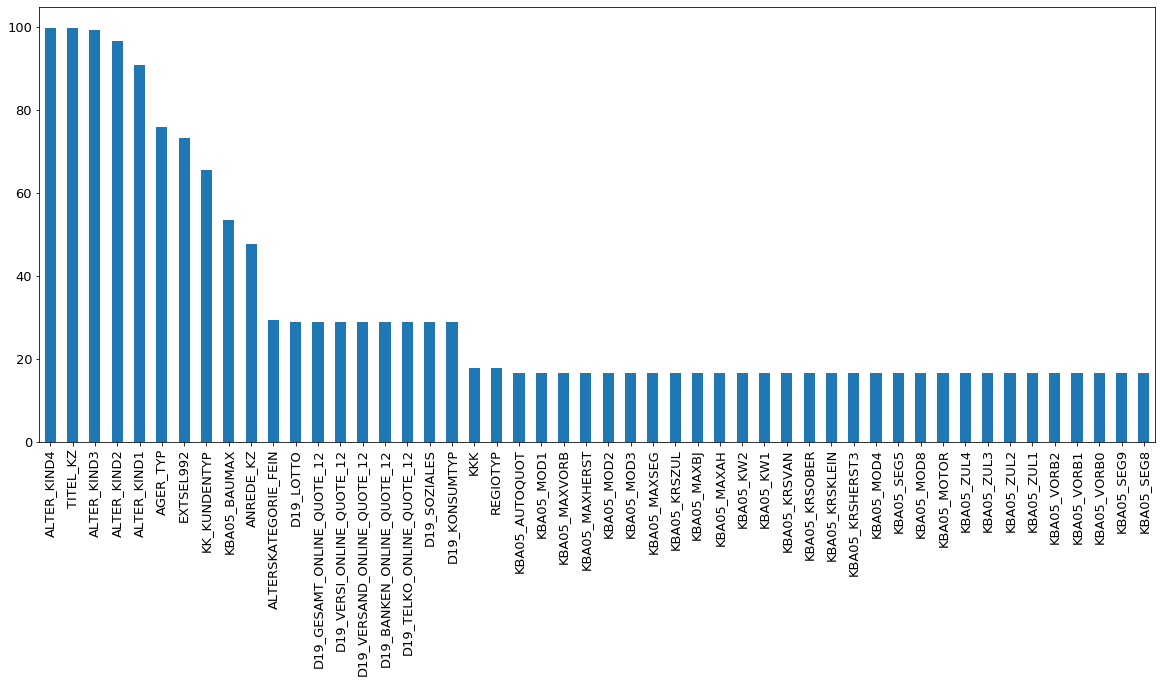

In [293]:
germany_col_report = get_missing_cdata(germany)
print(germany_col_report)

                       Attribute  Missing_Percentage
0                            LNR            0.000000
1                       AGER_TYP           48.059504
2                     AKT_DAT_KL           24.312817
3                       ALTER_HH           24.312817
4                    ALTER_KIND1           93.860748
5                    ALTER_KIND2           97.338927
6                    ALTER_KIND3           99.334732
7                    ALTER_KIND4           99.876860
8           ALTERSKATEGORIE_FEIN           27.050070
9            ANZ_HAUSHALTE_AKTIV           26.050863
10                  ANZ_HH_TITEL           27.189907
11                    ANZ_KINDER           24.312817
12                  ANZ_PERSONEN           24.312817
13    ANZ_STATISTISCHE_HAUSHALTE           26.050863
14                     ANZ_TITEL           24.312817
15                        ARBEIT           26.337320
16                      BALLRAUM           26.067560
17               CAMEO_DEUG_2015           26.

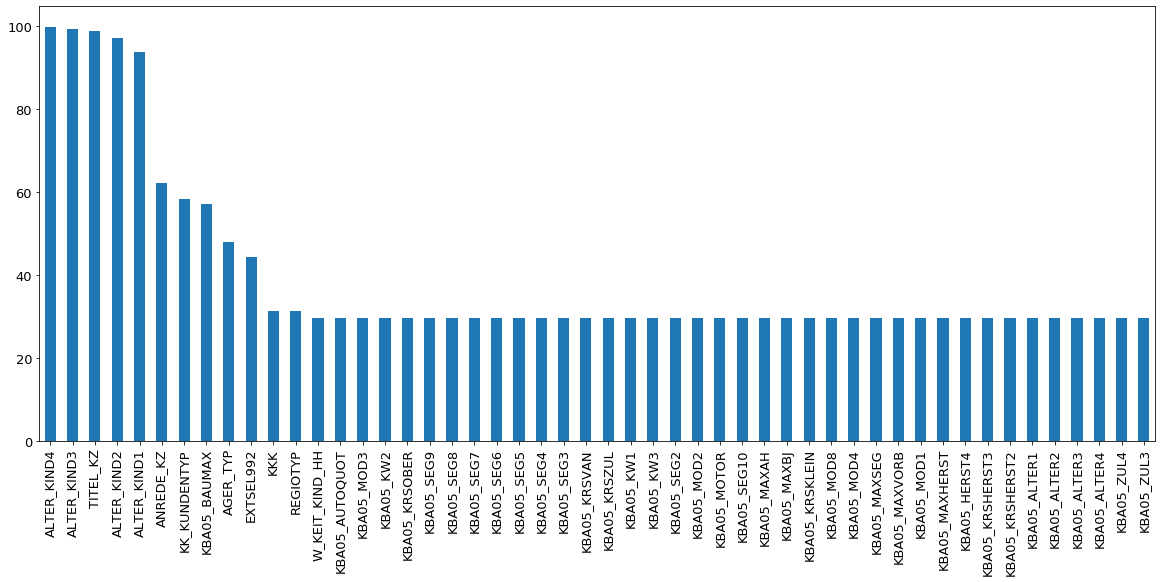

In [294]:
customer_col_report = get_missing_cdata(customer)
print(customer_col_report)

In [295]:
def drop_cols_with_missing_threshold(df, df_col_report, threshold = 65.0):
    # Drop cols from both tables at cut-off threshold from column graph (~65%)
    drop_col_data = df_col_report[df_col_report.Missing_Percentage > threshold]
    drop_cols_list = drop_col_data.Attribute.tolist()
    print('Columns to drop: ', drop_cols_list)
    df = df.drop(drop_cols_list,axis=1)
    return df

number of cols in germany before column filtering:  363
Columns to drop:  ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'TITEL_KZ']
number of cols in germany aftre column filtering:  355


,Attribute,Missing_Percentage
0,LNR,0.000000
1,AKT_DAT_KL,8.247000
2,ALTER_HH,8.247000
3,ALTERSKATEGORIE_FEIN,29.504130
4,ANZ_HAUSHALTE_AKTIV,10.451729
5,ANZ_HH_TITEL,10.884842
6,ANZ_KINDER,8.247000
7,ANZ_PERSONEN,8.247000
8,ANZ_STATISTISCHE_HAUSHALTE,10.451729
9,ANZ_TITEL,8.247000


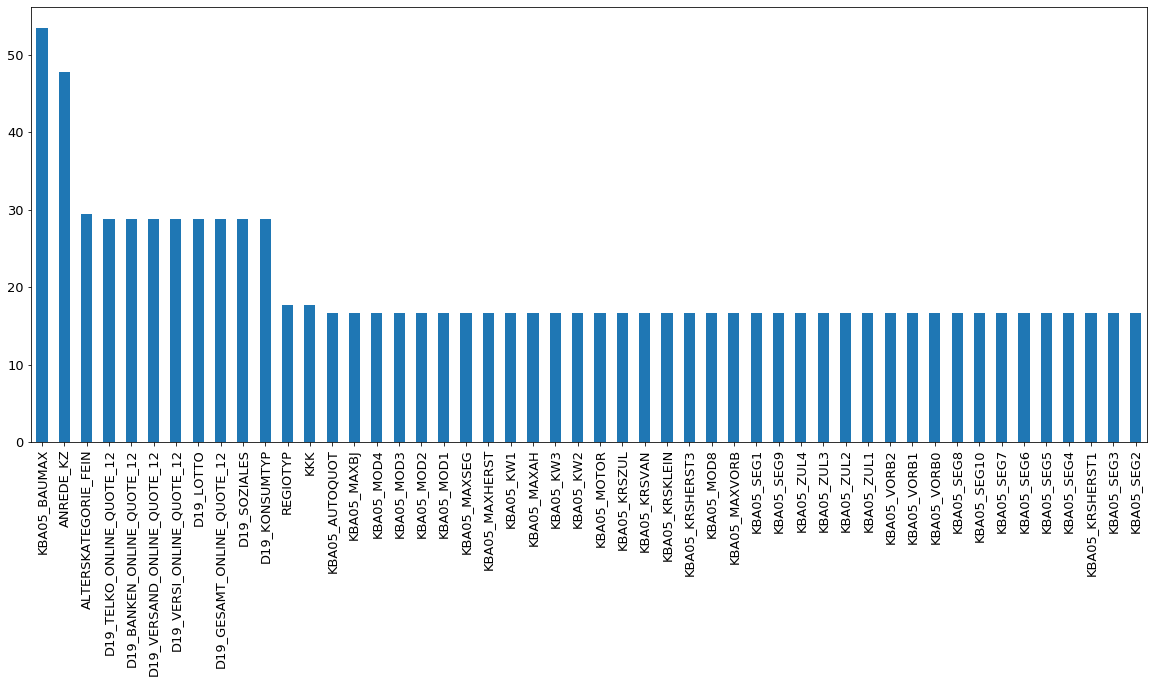

In [296]:
print('number of cols in germany before column filtering: ', len(germany.columns))
germany = drop_cols_with_missing_threshold(germany, germany_col_report)
print('number of cols in germany aftre column filtering: ', len(germany.columns))
get_missing_cdata(germany)

number of cols in customer before column filtering:  366
Columns to drop:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
number of cols in customer aftre column filtering:  361


,Attribute,Missing_Percentage
0,LNR,0.000000
1,AGER_TYP,48.059504
2,AKT_DAT_KL,24.312817
3,ALTER_HH,24.312817
4,ALTERSKATEGORIE_FEIN,27.050070
5,ANZ_HAUSHALTE_AKTIV,26.050863
6,ANZ_HH_TITEL,27.189907
7,ANZ_KINDER,24.312817
8,ANZ_PERSONEN,24.312817
9,ANZ_STATISTISCHE_HAUSHALTE,26.050863


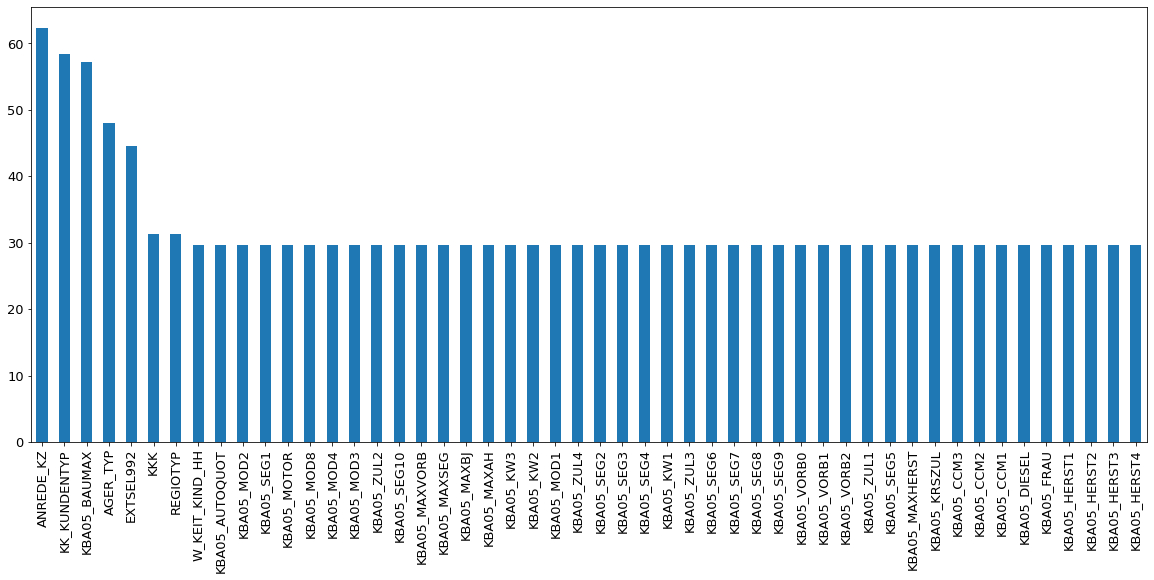

In [297]:
print('number of cols in customer before column filtering: ', len(customer.columns))
customer = drop_cols_with_missing_threshold(customer, customer_col_report)
print('number of cols in customer aftre column filtering: ', len(customer.columns))
get_missing_cdata(customer)

In [298]:
# Calculate distribution of data retained by rows

def plot_missing_row_plot(df1, df2, bins=20, figsize=(10,6)):
    
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("Rows vs Missing values")
    ax.set_xlabel("Total missing values")
    ax.set_ylabel("Total rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="germany")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="customer")
    ax.legend()
    
    plt.show()

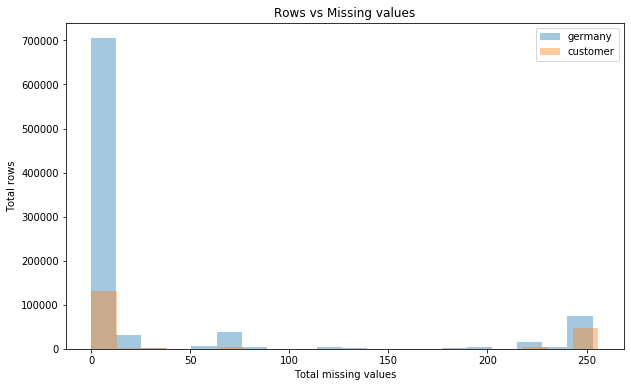

Final shape of germany dataset:  (891221, 355)
Final shape of customers dataset:  (191652, 361)


In [299]:
plot_missing_row_plot(germany, customer)

print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)

In [300]:
def drop_rows_with_missing_threshold(df, threshold=45, name=""):
    
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [301]:
customer = drop_rows_with_missing_threshold(customer, threshold=50)
germany = drop_rows_with_missing_threshold(germany, threshold=40)

		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe


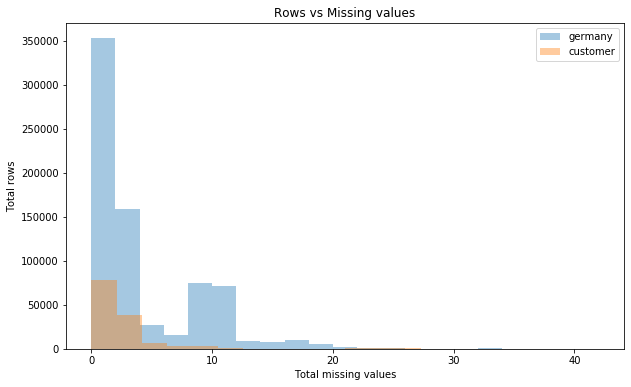

In [302]:
plot_missing_row_plot(germany, customer)

In [ ]:
%%time

# reduce dataset further by dropping columns that are highly correlated
# compute correlation matrix and drop when threshold crosses 70 %

def remove_corr_cols(df, df_name, corr_threshold = 0.7):
    
    comat = df.corr().abs()
    upper_limit = comat.where(np.triu(np.ones(comat.shape), k=1).astype(np.bool))
    
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > corr_threshold)]
    print('Cleaning up table: ', df_name)
    print('Columns to drop:', drop_columns)
    df = df.drop(drop_columns, axis=1)
    return df

germany = remove_corr_cols(df = germany, df_name = "germany")
customer = remove_corr_cols(df = customer, df_name = "customer")

print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)

In [ ]:
germany.info()
customer.info()


In [303]:
%%time

def clean_extra_cols(df1, df2):
    print("Number of columns in df1 Data - ", len(list(df1.columns)))
    print("Number of columns in df2 Data - ", len(list(df2.columns)))

    # drop extra cols in df1 data for this stage
    extra_cols = []
    for col in df1.columns:
        if col not in df2.columns:
            print(col)
            extra_cols.append(col)
        
    print("Extra columns in df1 Data - ",extra_cols)
    print("Extra columns in df1 Data - ",len(extra_cols))
    
    for col in extra_cols:
        df1 = df1.drop([col],axis=1)
        
    return df1

customer = clean_extra_cols(customer, germany)

Number of columns in df1 Data -  361
Number of columns in df2 Data -  355
AGER_TYP
EXTSEL992
KK_KUNDENTYP
PRODUCT_GROUP
CUSTOMER_GROUP
ONLINE_PURCHASE
Extra columns in df1 Data -  ['AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
Extra columns in df1 Data -  6
CPU times: user 389 ms, sys: 376 ms, total: 765 ms
Wall time: 762 ms


In [304]:
germany_vals = list(germany.columns.values)
print(germany)

customer_vals = list(customer.columns.values)
print(customer)

print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)

           LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0       910220         9.0       0.0                  21.0   
1       910225         9.0      17.0                  17.0   
2       910226         1.0      13.0                  13.0   
3       910241         1.0      20.0                  14.0   
4       910244         1.0      10.0                  10.0   
...        ...         ...       ...                   ...   
737283  825761         5.0      17.0                  17.0   
737284  825771         9.0      16.0                  16.0   
737285  825772         1.0      17.0                  17.0   
737286  825776         9.0       0.0                  20.0   
737287  825787         1.0       0.0                   NaN   

        ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0                      11.0           0.0         0.0           2.0   
1                      10.0           0.0         0.0           1.0   
2                       1.0           0.0 

### Part 0.3: Impution and scaling


In [305]:
### Part 0.2: Handle missing data and remove highly corelated data


In [306]:
imputer = SimpleImputer(strategy="most_frequent")

germany = imputer.fit_transform(germany)
germany = pd.DataFrame(germany)
print('imputed germany: ', germany.head(5))

imputed germany:          0    1     2     3     4    5    6    7     8    9    ...  345   346  \
0  910220.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  12.0  0.0  ...  4.0   8.0   
1  910225.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0   7.0  0.0  ...  2.0   9.0   
2  910226.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0   2.0  0.0  ...  0.0   7.0   
3  910241.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0   3.0  0.0  ...  2.0   3.0   
4  910244.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0   2.0  0.0  ...  2.0  10.0   

    347   348  349  350  351  352  353  354  
0  11.0  10.0  3.0  9.0  4.0  5.0  1.0  1.0  
1   9.0   6.0  3.0  9.0  2.0  5.0  1.0  3.0  
2  10.0  11.0  6.0  9.0  7.0  3.0  1.0  4.0  
3   5.0   4.0  2.0  9.0  3.0  4.0  1.0  3.0  
4   7.0   4.0  6.0  9.0  7.0  4.0  1.0  1.0  

[5 rows x 355 columns]


In [307]:
customer = imputer.fit_transform(customer)
customer = pd.DataFrame(customer)
print('imputed customer: ', customer.head(5))

imputed customer:          0    1     2     3    4    5    6    7    8    9    ...  345   346  \
0    9626.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  1.0  0.0  ...  3.0   5.0   
1  143872.0  1.0   6.0   0.0  1.0  0.0  0.0  1.0  1.0  0.0  ...  4.0  10.0   
2  143873.0  1.0   8.0   8.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  2.0   6.0   
3  143874.0  1.0  20.0  14.0  7.0  0.0  0.0  4.0  7.0  0.0  ...  4.0   3.0   
4  143888.0  1.0  11.0  10.0  1.0  0.0  0.0  2.0  1.0  0.0  ...  4.0   1.0   

    347   348  349  350  351  352  353  354  
0   3.0   2.0  6.0  9.0  7.0  3.0  1.0  4.0  
1  13.0  11.0  6.0  9.0  2.0  3.0  1.0  4.0  
2   4.0   2.0  6.0  9.0  7.0  1.0  1.0  4.0  
3   5.0   4.0  2.0  9.0  3.0  1.0  1.0  3.0  
4   2.0   1.0  6.0  9.0  1.0  2.0  1.0  3.0  

[5 rows x 355 columns]


In [308]:
print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)

Final shape of germany dataset:  (737288, 355)
Final shape of customers dataset:  (134246, 355)


In [309]:
%%time
# scale the data
scale = StandardScaler(copy=False)

germany[germany.columns] = scale.fit_transform(germany)
customer[customer.columns] = scale.fit_transform(customer)

CPU times: user 5.19 s, sys: 1.85 s, total: 7.04 s
Wall time: 7.03 s


In [310]:
# Let apply all transforms we did to cleanup the data so far
print('Final shape of germany dataset: ',germany.shape)
print('Final shape of customers dataset: ',customer.shape)


Final shape of germany dataset:  (737288, 355)
Final shape of customers dataset:  (134246, 355)


### Part 0.4: Final version of cleanup handler


In [311]:
def clean_dataset(df, df_name, unknown_attributes_values, use_scaler=True):    
    print("cleaning data....")
    # drop special cols
    df = remove_special_cols(df);
    
    # fix object values and wrong mappings
    df = fix_cameo_cols(df)
    df = fix_col_mappings(df)

    # all unknowns --> nan
    df = replace_unknowns(df, unknown_attributes_values, verbose=False)
    
    # missing value cols
    print("Removing missing cols....")
    df_col_report = get_missing_cdata(df)
    df = drop_cols_with_missing_threshold(df, df_col_report)
    
    # missing val rows
    print("Removing missing rows....")
    df = drop_rows_with_missing_threshold(df, threshold=50)
    
    # correlated col cleanup
    #print("Removing corr cols....")
    #df = remove_corr_cols(df = df, df_name = df_name)
    
    print("Imputing step....")
    imputer = SimpleImputer(strategy="most_frequent")
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns = df.columns)
    
    if use_scaler:
        # scale the data
        print("Scaling step....")
        scaler = StandardScaler()
        scaler.fit(df)
        df = pd.DataFrame(scaler.transform(df), columns = df.columns)
        print('shape after scaling', df.shape)
    
    return df

In [312]:
# load rae dataset again and run cleaner routine
germany, customer, attr_vals, attr_info = load_dataset()

customer = clean_extra_cols(customer, germany)

# Forward fill attribute_values dataframe, to access required columns and corresponding info
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]


Loading raw data


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Number of columns in df1 Data -  369
Number of columns in df2 Data -  366
PRODUCT_GROUP
CUSTOMER_GROUP
ONLINE_PURCHASE
Extra columns in df1 Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
Extra columns in df1 Data -  3


cleaning data....
Removing missing cols....
Columns to drop:  ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'TITEL_KZ']
Removing missing rows....
		Removed 153933 rows from  dataframe
Imputing step....
Scaling step....
shape after scaling (737288, 355)
(737288, 355)
        LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0  1.057636    1.262251 -1.430675              1.560767             0.186813   
1  1.057655    1.262251  0.801403              0.674377             0.120634   
2  1.057659   -0.934331  0.276209             -0.212013            -0.474979   
3  1.057717   -0.934331  1.195299              0.009584            -0.342620   
4  1.057729   -0.934331 -0.117688             -0.876806            -0.210262   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0     -0.125303   -0.299061      0.224688                    0.335407   
1     -0.125303   -0.299061     -0.634469         

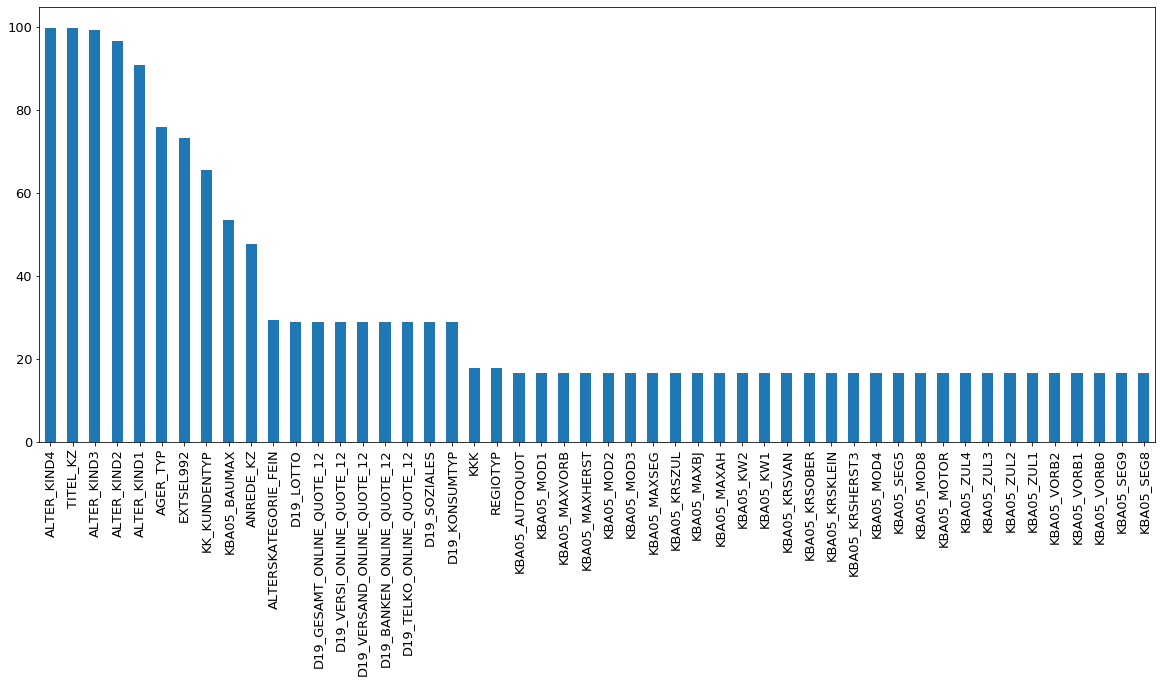

In [313]:
%%time
germany = clean_dataset(germany, 'germany', unknown_attributes_values)
print(germany.shape)
print(germany.head(5))

cleaning data....
Removing missing cols....
Columns to drop:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
Removing missing rows....
		Removed 57406 rows from  dataframe
Imputing step....
Scaling step....
shape after scaling (134246, 358)
(134246, 358)
        LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0 -1.559617  0.483428   -0.367858 -0.216129             -0.060895   
1  0.864757  0.483428   -0.367858 -0.855203             -2.543841   
2  0.864775 -1.114304   -0.367858 -0.535666             -0.557484   
3  0.864793  0.483428   -0.367858  1.381556              0.932284   
4  0.865046 -1.114304   -0.367858 -0.056360             -0.060895   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0            -0.274802      -0.12496   -0.265318     -0.207283   
1            -0.274802      -0.12496   -0.265318     -0.921821   
2            -0.347719      -0.12496   -0.265318     -1.636359   
3             0.162700      -0.12496   -

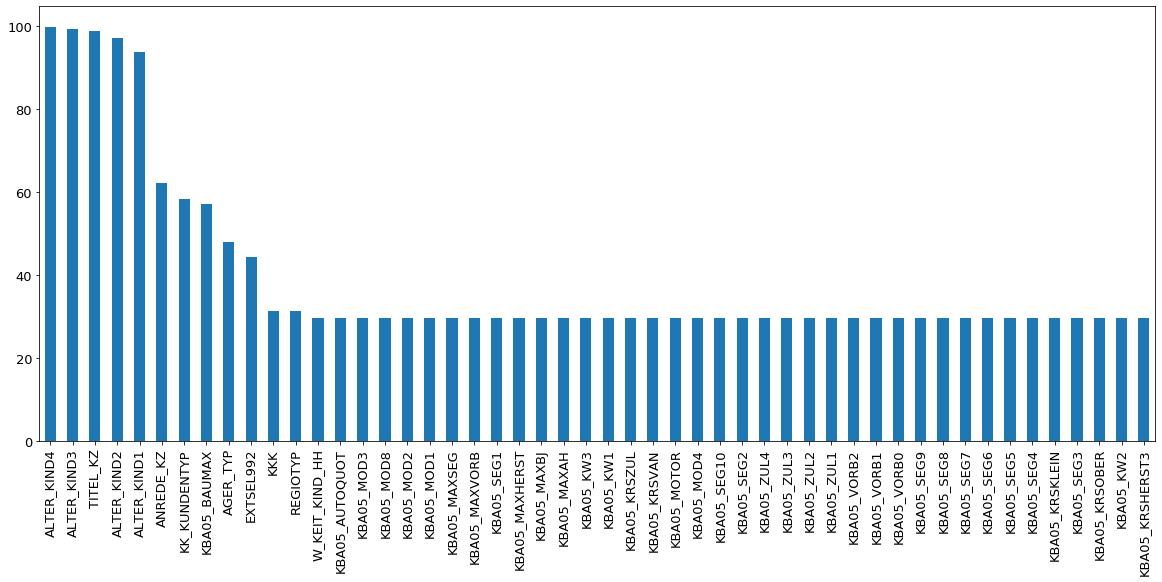

In [314]:
%%time
customer = clean_dataset(customer, 'customer', unknown_attributes_values)
print(customer.shape)
print(customer.head(5))

In [315]:
# Save cleaned data
#germany.to_csv(datafile_germany_clean, index=False)
#customer.to_csv(datafile_customer_clean, index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [43]:
#germany, customers, attributes_values, attributes_info = load_dataset(data_type="cleaned")

### Part 1.1: PCA analysis


In [44]:
def do_pca(data, n_components=None):
    pca = PCA(n_components, random_state=3)
    pca.fit(data)
    pca_result = pca.transform(data)
    return pca, pca_result

In [45]:
pca_germany, _ = do_pca(germany, None)

In [46]:
def plot_pca_exp_var(pca_germany, cumulative=True, figsize=(8,10)):
    
    if cumulative:
        germany_variance = np.cumsum(pca_germany.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        germany_variance = pca_germany.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(germany_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Germany - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

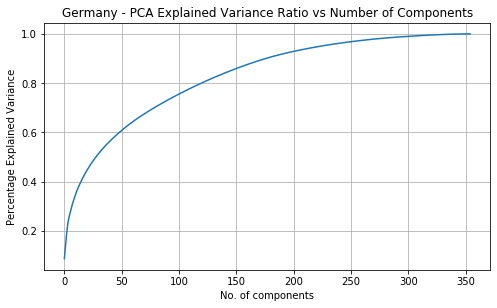

In [47]:
plot_pca_exp_var(pca_germany)

In [48]:
def reduce_data(df, n=200):
    pca = PCA(n_components=n)
    fit = pca.fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [49]:
# from the above graph, we have found a sweet spot at vairance cut-off around 200
# return reduced_data

reduced_germany = reduce_data(germany)
reduced_customer = reduce_data(customer)

0.9272808166543336
0.9179739336914244


In [50]:
print('shape of new germany dataset: ',reduced_germany.shape)
print('shape of new customer dataset: ',reduced_customer.shape)

shape of new germany dataset:  (737288, 200)
shape of new customer dataset:  (134246, 200)


In [51]:
reduced_germany.to_pickle('pca_germany.p')
reduced_customer.to_pickle('pca_customers.p')

### Part 1.2: K-means clustering


In [52]:
# k-means algorithm
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("K-Means clustering")
    print("Num clusters ranging from min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=3)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [53]:
# search k-means scores for different cluster sizes
%%time
scores, range_ = get_Kmeans_scores(reduced_germany, 2, 20, 1)

K-Means clustering
Num clusters ranging from min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  225930429.3609251
Time elapsed: 63.66 sec.

Training for n_clusters:  3
Done! Score:  218126234.0946828
Time elapsed: 95.91 sec.

Training for n_clusters:  4
Done! Score:  213641229.77458382
Time elapsed: 140.73 sec.

Training for n_clusters:  5
Done! Score:  209998055.08382806
Time elapsed: 200.59 sec.

Training for n_clusters:  6
Done! Score:  207144537.83034334
Time elapsed: 252.44 sec.

Training for n_clusters:  7
Done! Score:  204650465.01941106
Time elapsed: 288.45 sec.

Training for n_clusters:  8
Done! Score:  202551493.2226807
Time elapsed: 342.96 sec.

Training for n_clusters:  9
Done! Score:  200697204.27265745
Time elapsed: 384.49 sec.

Training for n_clusters:  10
Done! Score:  199325935.86931258
Time elapsed: 401.54 sec.

Training for n_clusters:  11
Done! Score:  198139794.41287187
Time elapsed: 464.91 sec.

Training for n_clusters:  12
Done! Score:  196988497.32

In [54]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="red")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

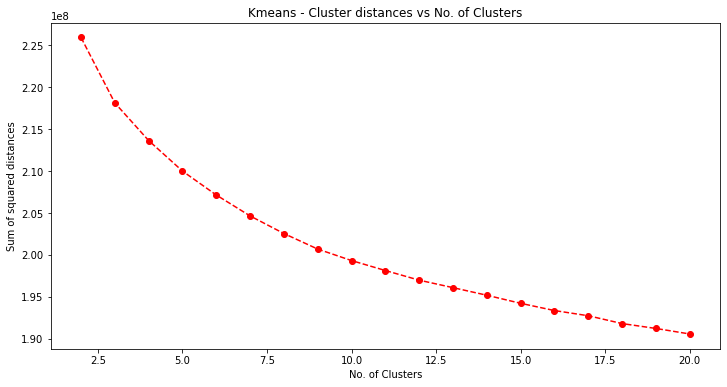

In [55]:
plot_elbow(scores, range_)

In [ ]:
# The elbow seems to be around 10 where the slope start to lower, so lets choose that as our cluster configuratoion.

In [56]:

%%time
kmeans = KMeans(10)
kmeans.fit(reduced_germany)

CPU times: user 8min 5s, sys: 5.74 s, total: 8min 10s
Wall time: 7min 22s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [66]:
germany_pred = kmeans.predict(reduced_germany)

In [67]:
customer_pred = kmeans.predict(reduced_customer)

In [68]:
print(germany_pred[:15], "\n",customer_pred[:15])

[2 2 5 6 5 2 2 7 7 3 2 2 9 8 2] 
 [4 1 4 7 6 8 0 1 6 8 3 1 8 8 9]


In [69]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(customer_pred)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(germany_pred)
pc = population_clusters.value_counts().sort_index()

In [70]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','germany','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['germany']/df_stat['germany'].sum()*100)
df_stat

,cluster,germany,customer,difference
0,0,46112,10818,1.804068
1,1,99544,12661,-4.070179
2,2,104362,16958,-1.522815
3,3,89865,22833,4.819740
4,4,51258,5209,-3.072046
5,5,97262,17021,-0.512897
6,6,61660,16811,4.159451
7,7,64653,10134,-1.220201
8,8,73914,11093,-1.761931
9,9,48658,10708,1.376810


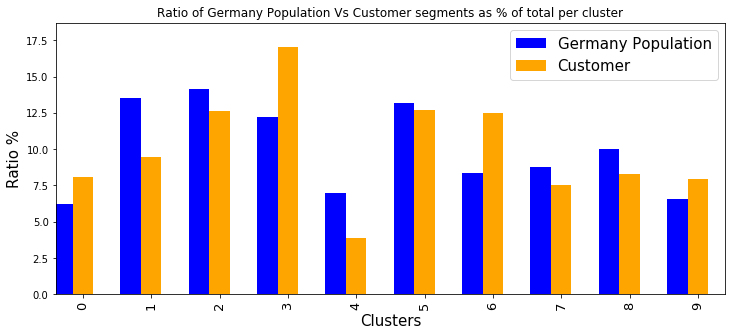

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['germany_percent'] = (df_stat['germany']/df_stat['germany'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['germany_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Germany Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Germany Population Vs Customer segments as % of total per cluster'))
plt.show()

In [78]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pca, pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = germany.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1).reindex(ratio.index)
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])


In [79]:
# Show highest positive and negative weights for 3 cluster (over representation of Customer)
pca_weights(pca_germany, 3,3)

Principal Component:  3


Highest Positive weights:
225    0.170
274    0.147
260    0.144
Name: 2, dtype: float64


Negative weights:
282   -0.140
269   -0.120
233   -0.119
Name: 2, dtype: float64


In [80]:
# Show lowest positive and negative weights for 4 cluster (under representation of Customer)
pca_weights(pca_germany, 4,5)

Principal Component:  4


Highest Positive weights:
97     0.145
354    0.140
20     0.136
18     0.123
19     0.121
Name: 3, dtype: float64


Negative weights:
95    -0.159
92    -0.155
16    -0.155
315   -0.155
96    -0.152
Name: 3, dtype: float64


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Part 2.1: Analyze training data


In [322]:
mailout_train = pd.read_csv(dataset_training, sep=';')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [323]:
mailout_train.shape

(42962, 367)

In [324]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


0    42430
1      532
Name: RESPONSE, dtype: int64


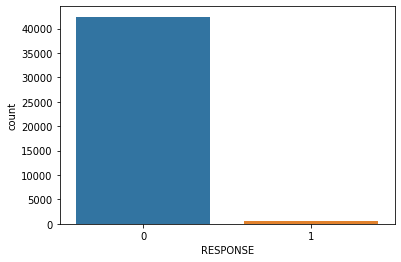

In [325]:

print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

In [326]:
labels = mailout_train["RESPONSE"]

In [327]:
X = mailout_train.drop('RESPONSE',axis=1)

### Part 2.2: Clean and run baseline model

The data is not balanced. 
Total negetives are > 40000 - 0 while only 532 - 1 positives. 

Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even 
if the model predicts all zeros. Since 42430/(42430+532)*100 = 98.7 %. 

In this case, we should use Precision and Recall or Area under Receiver Operating Curve (AUROC).


In [328]:
def clean_train_dataset(df, unknown_attributes_values):    
    print("cleaning training data....")

    # drop special cols
    df = remove_special_cols(df);
    
    # fix object values and wrong mappings
    df = fix_cameo_cols(df)
    
    df = fix_col_mappings(df)

    # all unknowns --> nan
    df = replace_unknowns(df, unknown_attributes_values, verbose=False)
    
    print("Imputing step....")
    imputer = SimpleImputer(strategy="most_frequent")
    scaled = imputer.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)
    
    return df

In [329]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]

df_train = clean_train_dataset(X, unknown_attributes_values)
print(df_train.shape)
print(df_train.head(5))

cleaning training data....
Imputing step....
(42962, 363)
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763.0       2.0         1.0       8.0         18.0         17.0   
1  1771.0       1.0         4.0      13.0         18.0         17.0   
2  1776.0       1.0         1.0       9.0         18.0         17.0   
3  1460.0       2.0         1.0       6.0         18.0         17.0   
4  1783.0       2.0         1.0       9.0         18.0         17.0   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0         18.0         13.0                   8.0                 15.0  ...   
1         18.0         13.0                  13.0                  1.0  ...   
2         18.0         13.0                   7.0                  0.0  ...   
3         18.0         13.0                   6.0                  4.0  ...   
4         18.0         13.0                   9.0                 53.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W

In [330]:
X_train, X_val, y_train, y_val = train_test_split(df_train, labels, stratify=labels, test_size=0.2, random_state=21)

In [331]:
lr = LogisticRegression(random_state=21)

In [332]:
lr.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [333]:
pred = lr.predict_proba(X_val)[:,1]
pred

array([0.00810306, 0.03134819, 0.00926207, ..., 0.00813819, 0.02009427,
       0.01995488])

In [334]:
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.6734639659768213


In [335]:
scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns = df_train.columns)

In [336]:
#!pip install xgboost
#import xgboost
#from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
#import xgboost as xgb

### Part 2.3: Evaluate different models


In [337]:
X_train, X_val, y_train, y_val = train_test_split(df_train, labels, stratify=labels, test_size=0.2, random_state=21)

In [338]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

In [347]:
rand_val = 21
models = [("LogisticRegression", LogisticRegression(random_state=rand_val)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=rand_val)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=rand_val)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=rand_val)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=rand_val))]

In [348]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [349]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.661797,0.828929
1,DecisionTreeClassifier,0.495998,2.22432
2,RandomForestClassifier,0.612349,8.96097
3,GradientBoostingClassifier,0.755596,49.6254
4,AdaBoostClassifier,0.733677,10.789


In [374]:
# https://educationalresearchtechniques.com/2019/01/02/adaboost-classification-in-python/
# For displaying max number of lines
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }


adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=21), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [ ]:
%%time
adaboost_grid.fit(X_train, y_train)

In [385]:
best_adaboost = adaboost_grid.best_estimator_

In [386]:
print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Best Score:  0.7616969553073047
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}


In [387]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7700


In [388]:
def plot_feature_contribution(model, model_name, feature_names, num_features=10):
    
    
    imp_values = np.zeros((len(model.feature_importances_)))
    imp_values += model.feature_importances_
    imp_values = pd.DataFrame({'feature': feature_names, 'importance': imp_values})

    # sort based on importance
    imp_values = imp_values.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    imp_values['normalized_importance'] = imp_values['importance'] / imp_values['importance'].sum()
    imp_values['cumulative_importance'] = np.cumsum(imp_values['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(imp_values.index[:num_features]))), 
                imp_values['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(imp_values.index[:num_features]))))
    ax.set_yticklabels(imp_values['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

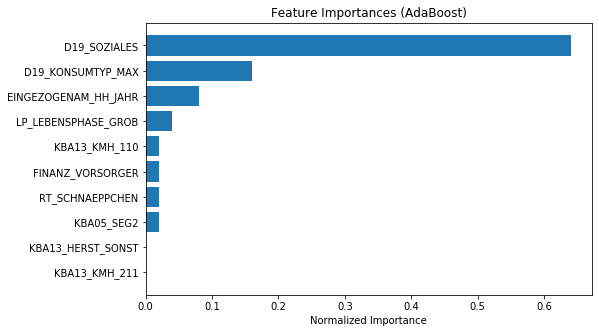

In [389]:
plot_feature_contribution(model=best_adaboost, model_name="AdaBoost", feature_names=df_train.columns)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [404]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep = ';')
print(mailout_train.columns)
print(mailout_test.columns)

mailout_test_LNR = mailout_test["LNR"]

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'RESPONSE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=367)
Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [405]:
# Lets make sure we have no difference in columns for train/test
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [406]:
print('before preprocessing shape: ', mailout_test.shape)
print(mailout_test.head(5))
df_test = clean_train_dataset(mailout_test, unknown_attributes_values)
print('after preprocessing shape: ', df_test.shape)
print(df_test.head(5))

before preprocessing shape:  (42833, 366)
    LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1754         2         1.0       7.0          NaN          NaN   
1  1770        -1         1.0       0.0          NaN          NaN   
2  1465         2         9.0      16.0          NaN          NaN   
3  1470        -1         7.0       0.0          NaN          NaN   
4  1478         1         1.0      21.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   6.0                  2.0  ...   
1          NaN          NaN                   0.0                 20.0  ...   
2          NaN          NaN                  11.0                  2.0  ...   
3          NaN          NaN                   0.0                  1.0  ...   
4          NaN          NaN                  13.0                  1.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_200

In [407]:
# scale data
df_test = pd.DataFrame(scaler.fit_transform(df_test), columns = df_test.columns)
print('after scaling shape: ', df_test.shape)

after scaling shape:  (42833, 363)


In [408]:
# train our best model on training data
best_adaboost.fit(df_train, labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=21)

In [409]:
prediction_for_kaggle = best_adaboost.predict_proba(df_test)[:,1]

In [410]:
print(prediction_for_kaggle)

[0.32386418 0.32884083 0.24355966 ... 0.32546924 0.30878661 0.32054129]


In [411]:
kaggle_gb = pd.DataFrame(index=mailout_test_LNR, data=prediction_for_kaggle)
kaggle_gb.rename(columns={0: "RESPONSE"}, inplace=True)

In [412]:
kaggle_gb.head(10)

,RESPONSE
LNR,
1754,0.323864
1770,0.328841
1465,0.243560
1470,0.244833
1478,0.260083
1782,0.246393
1485,0.256535
1519,0.325469
1835,0.327278


In [413]:
kaggle_gb.to_csv('submission.csv')